In [84]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [47]:
df = pd.read_csv("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv")

In [3]:
df.dtypes

lead_source                  object
industry                     object
number_of_courses_viewed      int64
annual_income               float64
employment_status            object
location                     object
interaction_count             int64
lead_score                  float64
converted                     int64
dtype: object

In [85]:
numerical = ["number_of_courses_viewed", "annual_income", "interaction_count", "lead_score"]
categorial = ['industry','employment_status', 'location', 'lead_source']
df[numerical] = df[numerical].fillna(value=0.0)
df[categorial] = df[categorial].fillna('NA')

In [86]:
from sklearn.model_selection import train_test_split
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values


del df_train['converted']
del df_val['converted']
del df_test['converted']

In [87]:
from sklearn.metrics import mutual_info_score
categorial.remove("converted") if "converted" in categorial else None
for catg in categorial:
  score = mutual_info_score(y_train, df_train[catg])
  print(f"for {catg}: {round(score,2)}")

for industry: 0.01
for employment_status: 0.02
for location: 0.0
for lead_source: 0.02


In [88]:
from sklearn.feature_extraction import DictVectorizer
def prepare_x(input_df):
    dicts = input_df.to_dict(orient="records")
    dv = DictVectorizer(sparse=False)
    dv.fit(dicts)
    return dv.transform(dicts)

from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=42)
X_train = prepare_x(df_train)
model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'liblinear'
,max_iter,1000
,multi_class,'deprecated'


In [52]:
X_val = prepare_x(df_val)

y_pred = model.predict_proba(X_val)[:, 1]

def calculate_accuracy(y_pred, y, threshold=0.5):
    df_pred = pd.DataFrame()
    df_pred['prob'] = y_pred
    df_pred['prediction'] = (y_pred >= threshold).astype(int)
    df_pred['actual'] = y_val
    df_pred['correct'] = df_pred.prediction == df_pred.actual
    return df_pred.correct.mean()

accuracy = calculate_accuracy(y_pred, y_val)
round(accuracy,2)

np.float64(0.7)

In [53]:
from sklearn.metrics import roc_auc_score
auc_numerical_features = {}

for num_feature in numerical:

    score = df_train[num_feature].values
    
    feature_auc = roc_auc_score(y_train, score)
    
    if feature_auc < 0.5:
        feature_auc = roc_auc_score(y_train, -score)
    
    auc_numerical_features[num_feature] = feature_auc


auc_numerical_features

{'number_of_courses_viewed': 0.7635680590007088,
 'annual_income': 0.5519578313253012,
 'interaction_count': 0.738270176293409,
 'lead_score': 0.6144993577250176}

In [54]:
auc_model = roc_auc_score(y_val, y_pred)
round(auc_model,3)

0.817

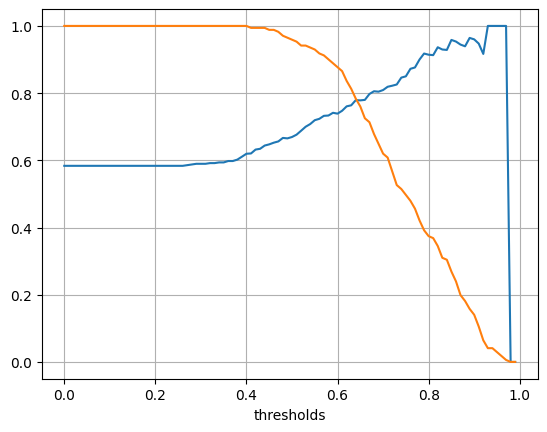

In [56]:
from sklearn.metrics import precision_score, recall_score
thresholds = np.arange(0.0, 1.0, 0.01)
precisions = []
recalls = []
y_model_pred = model.predict_proba(X_val)[:, 1]
for threshold in thresholds:
    y_pred = (y_model_pred >= threshold).astype(int)
    precision = precision_score(y_val, y_pred, zero_division=0)
    precisions.append(precision)
    
    recall = recall_score(y_val, y_pred, zero_division=0)
    recalls.append(recall)
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')

plt.xlabel('thresholds')

plt.grid(True)
plt.show()

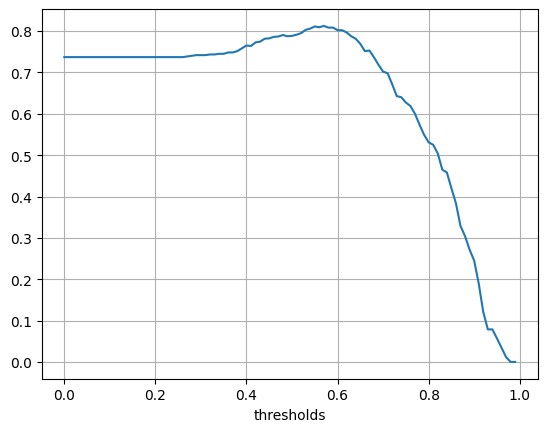

In [60]:
from sklearn.metrics import f1_score
thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = []

for threshold in thresholds:
    y_pred = (y_model_pred >= threshold).astype(int)
    
    # Calculate F1 score
    f1 = f1_score(y_val, y_pred, zero_division=0)
    f1_scores.append(f1)
plt.plot(thresholds, f1_scores, label='F1_Scores')

plt.xlabel('thresholds')

plt.grid(True)
plt.show()

In [105]:
from sklearn.model_selection import KFold

def predict(df, dv, model):
    dicts = df[categorial + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred
    
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorial + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model


kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

y_full_train = df_full_train.converted.values
for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=1.0)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
scores_std = np.std(scores)
round(scores_std, 3)

np.float64(0.036)

In [106]:
%pip install tqdm
from tqdm.auto import tqdm
n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


  0%|          | 0/7 [00:00<?, ?it/s]

C=0.001 0.867 +- 0.029
C=0.01 0.831 +- 0.034
C=0.1 0.823 +- 0.035
C=0.5 0.822 +- 0.036
C=1 0.822 +- 0.036
C=5 0.822 +- 0.036
C=10 0.822 +- 0.036
